In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import logging
import pandas as pd
import gensim
from gensim.models import KeyedVectors

logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')

In [2]:
# 预训练的词向量文件路径
vec_path = "word2vec.txt"  # 替换为实际路径
# 加载词向量文件
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(vec_path, binary=False)

# 获取原始词向量的维度
embedding_dim = word_vectors.vector_size

# 初始化词汇表，包含特殊标记
vocab = {'<unk>': 0, '[PAD]': 1}  # <unk> 和 [PAD] 的索引分别为 0 和 1

# 将原始词向量添加到词汇表中
for idx, word in enumerate(word_vectors.index_to_key, start=len(vocab)):
    vocab[word] = idx

# 更新 word_vectors，确保包含特殊标记
special_tokens = {'<unk>': np.random.uniform(-0.25, 0.25, embedding_dim),
                  '[PAD]': np.zeros(embedding_dim)}

for token, vector in special_tokens.items():
    if token not in word_vectors:
        word_vectors.add_vector(token, vector)

print("Vocabulary size:", len(vocab))

2025-01-24 12:47:47,770 INFO: loading projection weights from word2vec.txt
2025-01-24 12:47:48,164 INFO: KeyedVectors lifecycle event {'msg': 'loaded (5971, 200) matrix of type float32 from word2vec.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2025-01-24T12:47:48.164854', 'gensim': '4.3.3', 'python': '3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:48:34) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


Vocabulary size: 5973


E:\miniconda3\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [3]:
#数据集处理
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_vectors, max_len, unk_token='<unk>'):
        """
        文本数据集类
        :param texts: 文本数据列表，每个元素是一个词索引列表。
        :param labels: 标签列表，与 texts 中的文本一一对应。
        :param word_vectors: 词向量对象，包含词汇表和对应的词向量。
        :param max_len: 每个文本的最大长度，用于填充或截断文本。
        :param unk_token: 未知词标记，默认为 '<unk>'.
        """
        self.labels = labels
        self.word_vectors = word_vectors
        self.unk_token = unk_token
        self.max_len = max_len

        # 确保 <unk> 和 [PAD] 已经存在于 word_vectors 中
        assert '<unk>' in self.word_vectors.key_to_index, "Vocabulary does not contain '<unk>' token."
        assert '[PAD]' in self.word_vectors.key_to_index, "Vocabulary does not contain '[PAD]' token."

        # 填充或截断文本
        self.text = [self.pad_text(text, max_len) for text in texts]

    def pad_text(self, text, max_len):
        """
        填充或截断文本以匹配指定的最大长度
        :param text: 文本数据列表，每个元素是一个词索引列表。
        :param max_len: 每个文本的最大长度，用于填充或截断文本。
        """
        if not isinstance(text, list):
            raise ValueError("Expected a list of integers as input.")

        padded = text[:max_len]  # 截取前 max_len 个元素
        padding_needed = max_len - len(padded)
        if padding_needed > 0:
            padded.extend([self.word_vectors.key_to_index.get('[PAD]', 0)] * padding_needed)  # 使用[PAD]索引填充
        return padded

    def __len__(self):
        """返回数据集中样本的数量"""
        return len(self.labels)

    def __getitem__(self, index):
        """
        获取指定索引的数据
        :param index: 数据索引。
        :return: 一个元组，包含文本数据和对应的标签。
        """
        text_tensor = torch.tensor(self.text[index], dtype=torch.long)  # 只传递词索引
        label_tensor = torch.tensor(self.labels[index], dtype=torch.long)
        return text_tensor, label_tensor

In [4]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size,embedding_dim, hidden_dim, output_dim, num_layers, dropout,):
        """
        双向LSTM模型
        :param vocab_size: 词汇表大小。
        :param embedding_dim: 词嵌入维度。
        :param hidden_dim: LSTM隐藏层维度。
        :param output_dim: 输出维度。
        :param num_layers: LSTM层数。
        :param dropout: 丢弃率。
        """
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True,dropout=dropout if num_layers > 1 else 0)
        # 双向的LSTM，所以hidden_dim*2
        self.fc=nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden,cell) = self.lstm(embedded)
        #合并双向LSTM的最后一个时间步的隐藏状态
        # 如果num_layers > 1，则取最后一层的隐藏状态
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]),dim=1)
        out = self.fc(hidden)
        return out

In [4]:
class BiGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        """
        双向GRU模型
        :param vocab_size: 词汇表大小。
        :param embedding_dim: 词嵌入维度。
        :param hidden_dim: GRU隐藏层维度。
        :param output_dim: 输出维度。
        :param num_layers: GRU层数。
        :param dropout: 丢弃率。
        """
        super(BiGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # 使用 GRU 替换 LSTM，并保持其他参数相同
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # 双向的GRU，所以hidden_dim*2
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        gru_out, hidden = self.gru(embedded)
        # 合并双向GRU的最后一个时间步的隐藏状态
        # 如果num_layers > 1，则取最后一层的隐藏状态
        # 注意：GRU 的 hidden 状态形状为 (num_layers * num_directions, batch, hidden_size)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # 取最后两层的隐藏状态并连接
        out = self.fc(hidden)
        return out

In [5]:
import logging
import time

def train_model(model, dataloader, criterion, optimizer, num_epochs, scheduler=None, early_stopping_patience=3):
    """
    训练模型，包含提前停止机制
    :param model: 模型。
    :param dataloader: 数据加载器。
    :param criterion: 损失函数。
    :param optimizer: 优化器。
    :param num_epochs: 训练轮数。
    :param scheduler: 学习率调度器，默认为 None。
    :param early_stopping_patience: 提前停止的耐心值，默认为 3。
    :return: 训练后的模型和包含训练历史记录的字典。
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        logging.info(f'Epoch {epoch+1}/{num_epochs}')
        logging.info('-' * 10)

        start_time = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)

            logging.info('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.cpu().item())

            # 使用验证集上的损失更新学习率并检查提前停止条件
            if phase == 'val':
                if scheduler:
                    scheduler.step(epoch_loss)

                # 更新最佳验证损失
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    epochs_no_improve = 0
                    # 你可以选择在这里保存最佳模型
                else:
                    epochs_no_improve += 1
                    logging.info(f'Validation loss did not improve for {epochs_no_improve} epochs.')

                    if epochs_no_improve >= early_stopping_patience:
                        logging.info("Early stopping triggered.")
                        return model, history

        end_time = time.time()
        logging.info(f'Epoch {epoch+1} completed in {(end_time - start_time):.2f}s')

    return model, history

In [6]:
def plot_train_history(history):
    """
    绘制训练和验证损失及准确率随时间的变化图
    """
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 绘制损失变化
    ax1.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    # 绘制准确率变化
    ax2.plot(epochs, [acc * 100 for acc in history['train_acc']], label='Train Accuracy', marker='o')
    ax2.plot(epochs, [acc * 100 for acc in history['val_acc']], label='Validation Accuracy', marker='o')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [7]:
#载入数据
data_file = './data/train_set.csv'
data = pd.read_csv(data_file,sep='\t')
labels = data['label'].values
texts = data['text'].values

In [8]:
def text_to_int(text, vocab, max_len):
    int_list = [vocab.get(word, vocab['<unk>']) for word in text.split()]
    padded = int_list[:max_len]
    padding_needed = max_len - len(padded)
    if padding_needed > 0:
        padded.extend([vocab['[PAD]']] * padding_needed)
    return padded

In [9]:
#将文本转换为整数列表
texts_as_int_lists = [text_to_int(text, vocab, max_len=3000) for text in texts]

In [10]:
#分割数据集为训练集和验证集
X_train,X_test,y_train,y_test = train_test_split(texts_as_int_lists,labels,test_size=0.2,random_state=42)

#创建数据集对象
train_dataset = TextDataset(X_train,y_train,word_vectors,max_len=3000)
test_dataset = TextDataset(X_test,y_test,word_vectors,max_len=3000)

#创建数据加载器
dataloaders = {
    'train': DataLoader(train_dataset,batch_size=64,shuffle=True),
    'val': DataLoader(test_dataset,batch_size=64,shuffle=False)
}

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 初始化模型、损失函数和优化器
hidden_dim = 128  # LSTM 隐藏层维度
output_dim = 14  # 类别数量
model = BiLSTM(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=2,  # 使用两层LSTM
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 初始化模型、损失函数和优化器
hidden_dim = 128  # LSTM 隐藏层维度
output_dim = 14  # 类别数量
model = BiGRU(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=2,  # 使用两层LSTM
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)

In [28]:
#开始训练模型
trained_model, history = train_model(model,dataloaders,criterion,optimizer,num_epochs=12)

2025-01-24 09:29:55,904 INFO: Epoch 1/12
2025-01-24 09:29:55,904 INFO: ----------
2025-01-24 09:33:29,358 INFO: train Loss: 0.6169 Acc: 0.8155
2025-01-24 09:33:51,704 INFO: val Loss: 0.3345 Acc: 0.8993
2025-01-24 09:33:51,705 INFO: Epoch 2/12
2025-01-24 09:33:51,705 INFO: ----------
2025-01-24 09:37:26,133 INFO: train Loss: 0.3392 Acc: 0.8991
2025-01-24 09:37:48,496 INFO: val Loss: 0.2616 Acc: 0.9213
2025-01-24 09:37:48,497 INFO: Epoch 3/12
2025-01-24 09:37:48,497 INFO: ----------
2025-01-24 09:41:21,898 INFO: train Loss: 0.2321 Acc: 0.9293
2025-01-24 09:41:44,254 INFO: val Loss: 0.2057 Acc: 0.9368
2025-01-24 09:41:44,255 INFO: Epoch 4/12
2025-01-24 09:41:44,255 INFO: ----------
2025-01-24 09:45:18,078 INFO: train Loss: 0.1735 Acc: 0.9466
2025-01-24 09:45:40,492 INFO: val Loss: 0.1812 Acc: 0.9447
2025-01-24 09:45:40,492 INFO: Epoch 5/12
2025-01-24 09:45:40,493 INFO: ----------
2025-01-24 09:49:14,163 INFO: train Loss: 0.1421 Acc: 0.9558
2025-01-24 09:49:36,524 INFO: val Loss: 0.1652 Ac

In [13]:
#开始训练模型
trained_model, history = train_model(model,dataloaders,criterion,optimizer,num_epochs=12)

2025-01-24 12:48:38,138 INFO: Epoch 1/12
2025-01-24 12:48:38,139 INFO: ----------
2025-01-24 12:51:06,248 INFO: train Loss: 0.4054 Acc: 0.8766
2025-01-24 12:51:20,934 INFO: val Loss: 0.2039 Acc: 0.9376
2025-01-24 12:51:20,934 INFO: Epoch 1 completed in 162.79s
2025-01-24 12:51:20,935 INFO: Epoch 2/12
2025-01-24 12:51:20,935 INFO: ----------
2025-01-24 12:53:48,128 INFO: train Loss: 0.1609 Acc: 0.9493
2025-01-24 12:54:02,822 INFO: val Loss: 0.1580 Acc: 0.9505
2025-01-24 12:54:02,822 INFO: Epoch 2 completed in 161.89s
2025-01-24 12:54:02,823 INFO: Epoch 3/12
2025-01-24 12:54:02,823 INFO: ----------
2025-01-24 12:56:30,210 INFO: train Loss: 0.1265 Acc: 0.9597
2025-01-24 12:56:44,826 INFO: val Loss: 0.1548 Acc: 0.9526
2025-01-24 12:56:44,827 INFO: Epoch 3 completed in 162.00s
2025-01-24 12:56:44,827 INFO: Epoch 4/12
2025-01-24 12:56:44,828 INFO: ----------
2025-01-24 12:59:12,095 INFO: train Loss: 0.1035 Acc: 0.9662
2025-01-24 12:59:26,749 INFO: val Loss: 0.1536 Acc: 0.9541
2025-01-24 12:5

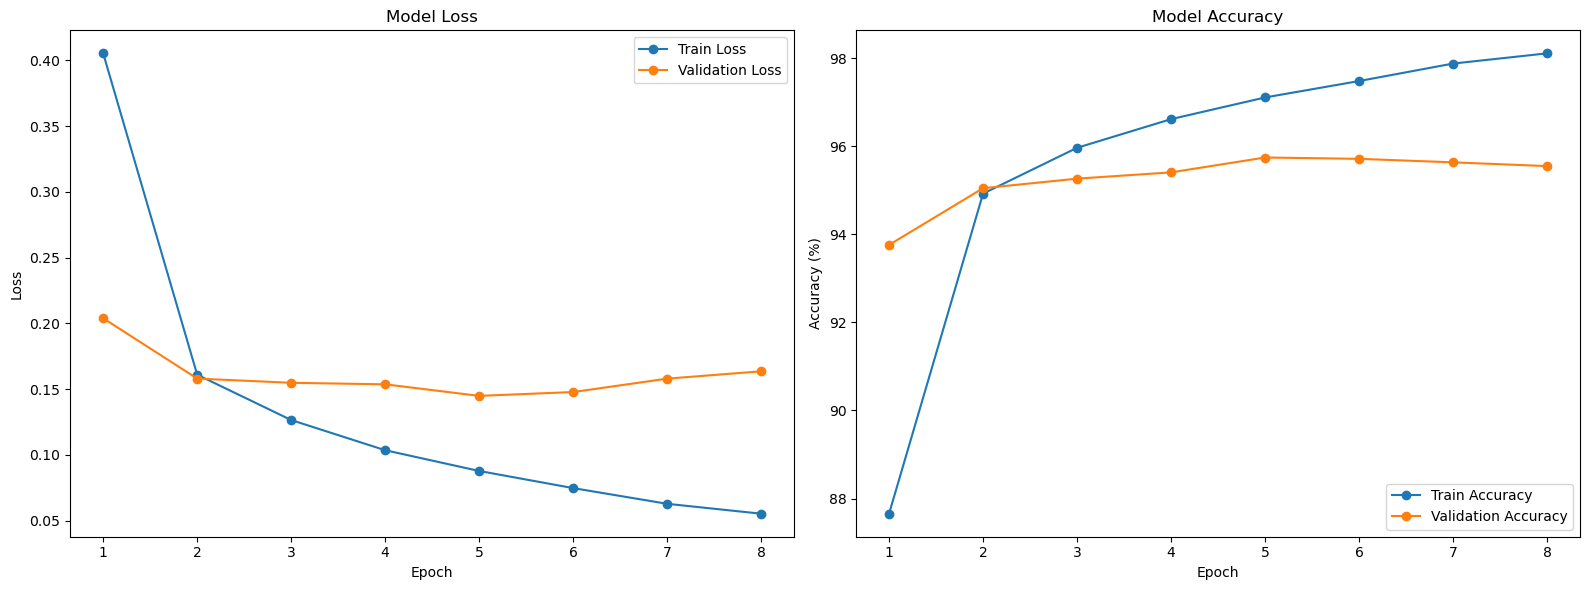

In [21]:
plot_train_history(history)

In [15]:
#保存模型
# 保存模型参数到文件
torch.save(trained_model.state_dict(), 'models/word2vec_RNN_BiGRU.pth')

In [16]:
# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型的状态字典
# 首先创建一个与原模型架构相同的实例
model = BiGRU(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=2,  # 使用两层LSTM
    dropout=0.2
)

# 然后加载状态字典
model.load_state_dict(torch.load('models/word2vec_RNN_BiGRU.pth', map_location=device,weights_only=True))
model.to(device)  # 将模型移动到相应的设备上
model.eval()  # 切换到评估模式

BiGRU(
  (embedding): Embedding(5973, 200, padding_idx=0)
  (gru): GRU(200, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=14, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [17]:
#构造测试数据集
test_data_file = './data/test_a.csv'
test_data = pd.read_csv(test_data_file,sep='\t')
test_texts = test_data['text'].values
test_texts_as_int_lists = [text_to_int(text, vocab, max_len=3000) for text in test_texts]
test_dataset = TextDataset(test_texts_as_int_lists, [0] * len(test_texts_as_int_lists), word_vectors, max_len=900)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
#预测新数据
def predict(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # 将模型移动到相应的设备
    model.eval()      # 切换到评估模式
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:  # 假设新数据没有标签
            inputs = inputs.to(device) # 将数据移动到相应的设备
            outputs = model(inputs)
            # 对于分类任务，通常会使用softmax函数将输出转换为概率分布，然后选择具有最高概率的类别作为预测结果。直接使用torch.max函数获取每行的最大值及其索引。只关心类别索引（预测标签），所以第二个返回值preds就是需要的结果
            _, preds = torch.max(outputs, 1)
            # # 将预测结果从PyTorch张量转换为NumPy数组，并添加到predictions列表中。.cpu()方法确保即使原始张量位于GPU上，也可以安全地转换为NumPy格式。
            predictions.extend(preds.cpu().numpy())
    return predictions

In [19]:
predictions = predict(model, test_dataloader)

In [20]:
pd.DataFrame(predictions,columns=['label']).to_csv('models/word2vec_textRNN_submit.csv', index=False)